In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import collections
import os
import random
import torch
import numpy as np
import time
import torch.utils.data as Data
import torchtext
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from gensim.models import Word2Vec

In [3]:
# Read the data

def read_data(folder='train', data_root='/content/drive/MyDrive/'):
    data = []
    for label in ['pos', 'neg']:
        folder_name = os.path.join(data_root, folder, label)
        for file in tqdm(os.listdir(folder_name)):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '').lower()
                data.append([review, 1 if label == 'pos' else 0])
    random.shuffle(data)
    return data

DATA_ROOT = '/content/drive/MyDrive'
data_root = os.path.join(DATA_ROOT, "aclImdb")
train_data, test_data = read_data('train', data_root), read_data('test', data_root)

100%|██████████| 12500/12500 [00:14<00:00, 840.18it/s] 


In [4]:
# build the function we need in the next steps 

def tokenizer(data):
    return [word.lower() for word in data.split(' ')]

def get_tokenized_data(data):
    return [tokenizer(review) for review, _ in data]

def get_vocab_data(data):
    tokenized_data = get_tokenized_data(data)
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    return vocab(counter,min_freq=10)

vocab = get_vocab_data(train_data) # This is used for filter some words have low frequency

In [18]:
plt.style.use('ggplot')

def result_plot(train_loss,train_acc,test_record):
  plt.figure()
  plt.plot(train_loss)
  plt.title('train_loss')
  plt.figure()
  plt.plot(train_acc)
  plt.title('train_accuracy')
  plt.figure()
  plt.plot(test_record)
  plt.title('test_accuracy')

# **Part1 TF-IDF**

In [6]:
# calculate TD-IDF results

def TF_IDF_trans(word,counter1,counter2):
  TF1 = counter1[word]
  TF2 = counter2[word]
  flag1 = 1 if TF1!=0 else 0
  flag2 = 1 if TF2!=0 else 0
  IDF = np.log((2+1)/(flag1+flag2+1))+1
  return [TF1*IDF,TF2*IDF]

In [7]:
cato1 = [train_data[i] for i in range(len(train_data)) if train_data[i][1] == 1] # positive review
cato2 = [train_data[i] for i in range(len(train_data)) if train_data[i][1] == 0] # negative review
cato1 = get_tokenized_data(cato1)
cato2 = get_tokenized_data(cato2)
counter1 = collections.Counter([tk for st in cato1 for tk in st]) #used to calculate TF-IDF
counter2 = collections.Counter([tk for st in cato2 for tk in st]) #used to calculate TF-IDF

In [8]:
tokenized_data = get_tokenized_data(train_data)
embedding = {} # record the TD-IDF results
for words in tokenized_data:
  for word in words:
    if word not in embedding:
      embedding[word] = TF_IDF_trans(word,counter1,counter2)

In [9]:
# Preprocess the data

def pad(x):
    max_l = 500 
    return x[:max_l] if len(x) > max_l else x + [[0,0]] * (max_l -len(x))

def preprocess_data(data, embedding):
  tokenized_data = get_tokenized_data(data)
  features = torch.tensor([pad([embedding[word] for word in words if word in embedding and word in vocab]) for words in tokenized_data])
  labels = torch.tensor([score for _, score in data])
  return features, labels

In [10]:
# Create data iterator

batch_size = 64
train_set = Data.TensorDataset(*preprocess_data(train_data, embedding))
test_set = Data.TensorDataset(*preprocess_data(test_data, embedding))
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

In [11]:
# check the data

for X, y in train_iter:
  print('X', X.shape, 'y', y.shape)
  break

X torch.Size([64, 500, 2]) y torch.Size([64])


In [19]:
# Create Bi-LSTM model

class BiLSTM(nn.Module):
  def __init__(self, embed_size, num_hiddens, num_layers):
    super(BiLSTM, self).__init__()
    self.LSTM = nn.LSTM(input_size=embed_size,hidden_size=num_hiddens,num_layers=num_layers,bidirectional=True)
    self.fc = nn.Linear(4*num_hiddens, 2)
    self.dropout = nn.Dropout(0.8)
  def forward(self, inputs):
    inputs = inputs.float()
    outputs, _ = self.LSTM(inputs.permute(1,0,2))
    outputs = self.dropout(outputs)
    result = torch.cat((outputs[0], outputs[-1]), -1)
    result = self.fc(result)
    return result 

In [20]:
# Parameters we need

embed_size, num_hiddens, num_layers = 2, 100, 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr, num_epochs = 0.001, 10
train_loss = []
train_acc = []
test_record = []

In [21]:
net = BiLSTM(embed_size, num_hiddens, num_layers)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

In [22]:
def evaluate_accuracy(data_iter, net,device):
  acc_sum, n = 0.0, 0
  with torch.no_grad():
    for X, y in data_iter:
      net.eval()
      acc_sum += (net(X.to(device)).argmax(dim=1) ==y.to(device)).float().sum().cpu().item()
      net.train()
      n += y.shape[0]
  return acc_sum / n

In [23]:
def train(train_iter, test_iter, net, loss, optimizer, device,num_epochs):
  net = net.to(device)
  batch_count = 0
  for epoch in range(num_epochs):
    train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter: 
      optimizer.zero_grad()
      X = X.to(device) 
      y = y.to(device)
      y_hat = net(X) 
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      train_loss_sum += l.cpu().item()
      train_acc_sum += (y_hat.argmax(dim=1) ==y).sum().cpu().item()
      n += y.shape[0]
      batch_count += 1
    test_acc = evaluate_accuracy(test_iter, net,device)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_loss_sum / batch_count,train_acc_sum / n, test_acc))
    train_loss.append(train_loss_sum / batch_count)
    train_acc.append(train_acc_sum / n)
    test_record.append(test_acc)

epoch 1, loss 0.3035, train acc 0.881, test acc 0.830
epoch 2, loss 0.1191, train acc 0.909, test acc 0.833
epoch 3, loss 0.0780, train acc 0.909, test acc 0.838
epoch 4, loss 0.0561, train acc 0.913, test acc 0.822
epoch 5, loss 0.0437, train acc 0.915, test acc 0.843
epoch 6, loss 0.0365, train acc 0.915, test acc 0.841
epoch 7, loss 0.0304, train acc 0.915, test acc 0.837
epoch 8, loss 0.0265, train acc 0.917, test acc 0.835
epoch 9, loss 0.0234, train acc 0.917, test acc 0.839
epoch 10, loss 0.0208, train acc 0.917, test acc 0.827


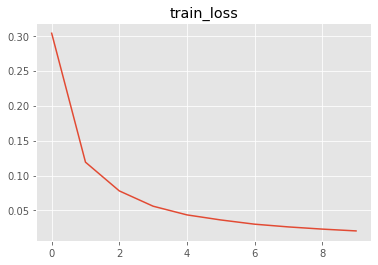

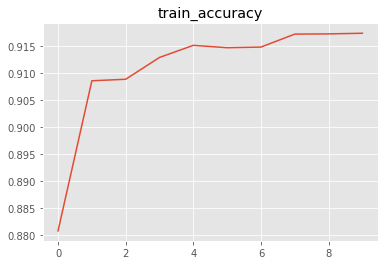

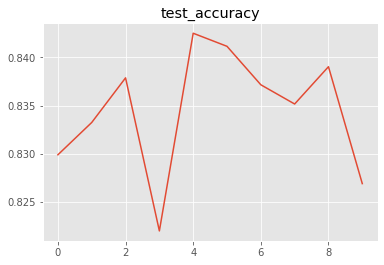

In [24]:
train(train_iter, test_iter, net, loss, optimizer, device,num_epochs)
result_plot(train_loss,train_acc,test_record)

# **Part2 GloVe**

In [25]:
glove = torchtext.vocab.GloVe(name='6B', dim=100, cache = os.path.join(DATA_ROOT,'glove'))

100%|█████████▉| 399999/400000 [00:13<00:00, 30062.71it/s]


In [26]:
# Preprocess the data

def pad(x):
    max_l = 500 
    return x[:max_l] if len(x) > max_l else x + [0] * (max_l -len(x))

def preprocess_data(data, vocab):
  tokenized_data = get_tokenized_data(data)
  stoi = vocab.get_stoi()
  features = torch.tensor([pad([stoi[word] for word in words if word in vocab]) for words in tokenized_data])
  labels = torch.tensor([score for _, score in data])
  return features, labels

In [27]:
# Create data iterator

batch_size = 64
train_set = Data.TensorDataset(*preprocess_data(train_data, vocab))
test_set = Data.TensorDataset(*preprocess_data(test_data, vocab))
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

In [28]:
# check the data

for X, y in train_iter:
  print('X', X.shape, 'y', y.shape)
  break

X torch.Size([64, 500]) y torch.Size([64])


In [29]:
# Create Bi-LSTM model

class BiLSTM(nn.Module):
  def __init__(self, embed_size, num_hiddens, num_layers):
    super(BiLSTM, self).__init__()
    self.embedding = nn.Embedding(len(vocab),embed_size)
    self.LSTM = nn.LSTM(input_size=embed_size,hidden_size=num_hiddens,num_layers=num_layers,bidirectional=True)
    self.fc = nn.Linear(4*num_hiddens, 2)
    self.dropout = nn.Dropout(0.8)
  def forward(self, inputs):
    #inputs = inputs.float()
    embeddings = self.embedding(inputs.permute(1,0))
    outputs, _ = self.LSTM(embeddings)
    outputs = self.dropout(outputs)
    result = torch.cat((outputs[0], outputs[-1]), -1)
    result = self.fc(result)
    return result 

In [30]:
# Use GloVe weight to embedding the word

def pretrained_embedding(words,pretrained):
  result = torch.zeros(len(words),pretrained.vectors[0].shape[0])
  for i,word in enumerate(words):
    try:
      result[i,:] = pretrained.vectors[pretrained.stoi[word]]
    except:
      continue
  return result

In [31]:
# Parameters we need

embed_size, num_hiddens, num_layers = 100, 100, 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr, num_epochs = 0.001, 10
train_loss = []
train_acc = []
test_record = []

In [32]:
net = BiLSTM(embed_size, num_hiddens, num_layers)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
net.embedding.weight.data.copy_(pretrained_embedding(vocab.get_itos(),glove))
net.embedding.weight.requires_grad = False

epoch 1, loss 0.6745, train acc 0.568, test acc 0.505
epoch 2, loss 0.3376, train acc 0.579, test acc 0.548
epoch 3, loss 0.2283, train acc 0.548, test acc 0.553
epoch 4, loss 0.1664, train acc 0.600, test acc 0.522
epoch 5, loss 0.1380, train acc 0.526, test acc 0.535
epoch 6, loss 0.0986, train acc 0.683, test acc 0.791
epoch 7, loss 0.0635, train acc 0.806, test acc 0.822
epoch 8, loss 0.0508, train acc 0.822, test acc 0.833
epoch 9, loss 0.0418, train acc 0.839, test acc 0.827
epoch 10, loss 0.0363, train acc 0.843, test acc 0.840


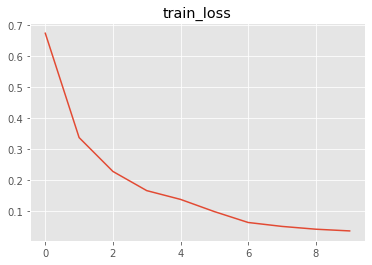

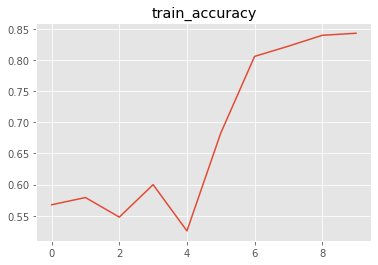

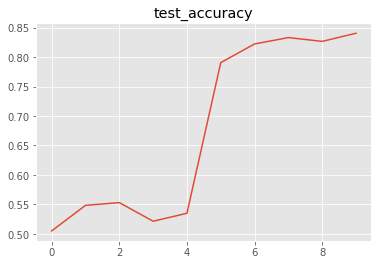

In [33]:
train(train_iter, test_iter, net, loss, optimizer, device,num_epochs)
result_plot(train_loss,train_acc,test_record)

# **Part3 Word2Vec**

In [34]:
# Train the Word2Vec model

tokenized_data = get_tokenized_data(train_data)
w2v_model = Word2Vec(sentences=tokenized_data,size=100,min_count=10,workers=1)

In [35]:
# Create Bi-LSTM model

class BiLSTM(nn.Module):
  def __init__(self, embed_size, num_hiddens, num_layers):
    super(BiLSTM, self).__init__()
    self.embedding = nn.Embedding(len(vocab),embed_size)
    self.LSTM = nn.LSTM(input_size=embed_size,hidden_size=num_hiddens,num_layers=num_layers,bidirectional=True)
    self.fc = nn.Linear(4*num_hiddens, 2)
    self.dropout = nn.Dropout(0.8)
  def forward(self, inputs):
    #inputs = inputs.float()
    embeddings = self.embedding(inputs.permute(1,0))
    outputs, _ = self.LSTM(embeddings)
    outputs = self.dropout(outputs)
    result = torch.cat((outputs[0], outputs[-1]), -1)
    result = self.fc(result)
    return result 

In [36]:
# Use Word2Vec weight to embedding the word

def pretrained_embedding(words,pretrained):
  result = torch.zeros(len(words),pretrained.wv.vectors[0].shape[0])
  for i,word in enumerate(words):
    try:
      result[i,:] = torch.tensor(pretrained.wv.get_vector(word))
    except:
      continue
  return result

In [37]:
# Parameters we need

embed_size, num_hiddens, num_layers = 100, 100, 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr, num_epochs = 0.001, 10
train_loss = []
train_acc = []
test_record = []

In [38]:
net = BiLSTM(embed_size, num_hiddens, num_layers)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
net.embedding.weight.data.copy_(pretrained_embedding(vocab.get_itos(),w2v_model))
net.embedding.weight.requires_grad = False

epoch 1, loss 0.6032, train acc 0.671, test acc 0.736
epoch 2, loss 0.3007, train acc 0.674, test acc 0.680
epoch 3, loss 0.1761, train acc 0.749, test acc 0.694
epoch 4, loss 0.1233, train acc 0.777, test acc 0.799
epoch 5, loss 0.0865, train acc 0.816, test acc 0.823
epoch 6, loss 0.0789, train acc 0.779, test acc 0.835
epoch 7, loss 0.0542, train acc 0.841, test acc 0.859
epoch 8, loss 0.0428, train acc 0.860, test acc 0.861
epoch 9, loss 0.0341, train acc 0.877, test acc 0.874
epoch 10, loss 0.0285, train acc 0.885, test acc 0.881


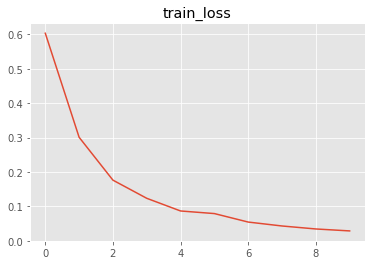

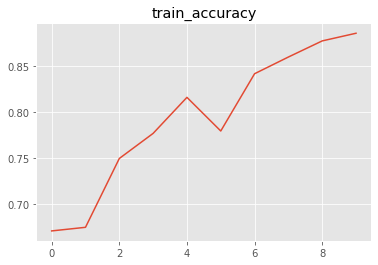

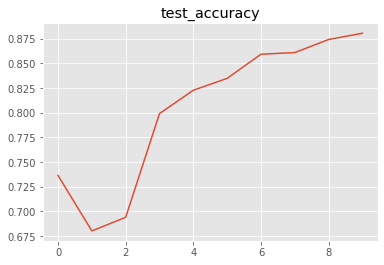

In [39]:
train(train_iter, test_iter, net, loss, optimizer, device,num_epochs)
result_plot(train_loss,train_acc,test_record)

# **Part4 Regular Embedding Layer**

In [40]:
# Create Bi-LSTM model

class BiLSTM(nn.Module):
  def __init__(self, embed_size, num_hiddens, num_layers):
    super(BiLSTM, self).__init__()
    self.embedding = nn.Embedding(len(vocab),embed_size)
    self.LSTM = nn.LSTM(input_size=embed_size,hidden_size=num_hiddens,num_layers=num_layers,bidirectional=True)
    self.fc = nn.Linear(4*num_hiddens, 2)
    self.dropout = nn.Dropout(0.8)
  def forward(self, inputs):
    #inputs = inputs.float()
    embeddings = self.embedding(inputs.permute(1,0))
    outputs, _ = self.LSTM(embeddings)
    outputs = self.dropout(outputs)
    result = torch.cat((outputs[0], outputs[-1]), -1)
    result = self.fc(result)
    return result 

In [41]:
# Parameters we need

embed_size, num_hiddens, num_layers = 100, 100, 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr, num_epochs = 0.001, 10
train_loss = []
train_acc = []
test_record = []

In [42]:
net = BiLSTM(embed_size, num_hiddens, num_layers)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

epoch 1, loss 0.6590, train acc 0.598, test acc 0.672
epoch 2, loss 0.2910, train acc 0.694, test acc 0.712
epoch 3, loss 0.1663, train acc 0.768, test acc 0.744
epoch 4, loss 0.1052, train acc 0.818, test acc 0.773
epoch 5, loss 0.0677, train acc 0.862, test acc 0.797
epoch 6, loss 0.0472, train acc 0.887, test acc 0.777
epoch 7, loss 0.0342, train acc 0.907, test acc 0.806
epoch 8, loss 0.0291, train acc 0.907, test acc 0.800
epoch 9, loss 0.0197, train acc 0.935, test acc 0.790
epoch 10, loss 0.0128, train acc 0.955, test acc 0.811


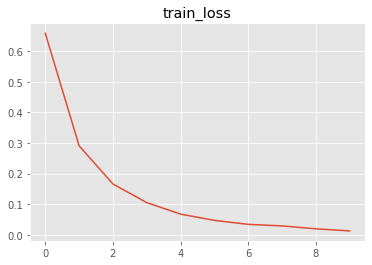

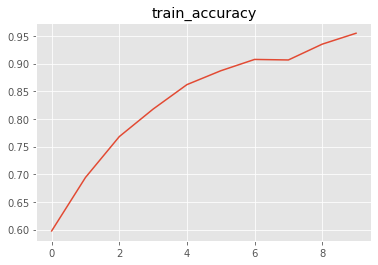

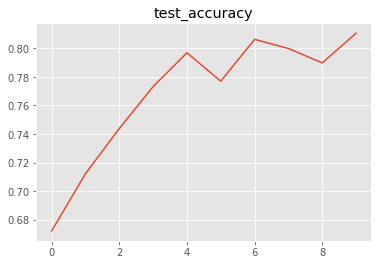

In [43]:
train(train_iter, test_iter, net, loss, optimizer, device,num_epochs)
result_plot(train_loss,train_acc,test_record)